In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from time import sleep
import yfinance as yf
import datetime

In [2]:
bbh =  ['BP', 'SHEL']
other_etfs = ['SPY', 'IBB', 'XBI', 'FBT', 'PBE', 'BIB']
symbols = bbh + other_etfs

In [3]:
start = datetime.datetime(2022, 1, 1)
end = datetime.datetime(2022, 12, 31)
result_dict = {}
for ticker in symbols:
    y_data = yf.download(ticker, start=start, end=end)
    closes = pd.Series(y_data['Adj Close'])
    result_dict[ticker] = closes

data = pd.DataFrame(result_dict)
data.head(3)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,BP,SHEL,SPY,IBB,XBI,FBT,PBE,BIB
Date,,,,,,,,
2022-01-03,25.052795,41.769161,464.923431,151.588593,115.436050,163.070007,71.414108,82.282516
2022-01-04,26.132891,43.013634,464.767639,147.529526,111.356194,159.059998,68.724709,78.313835
2022-01-05,25.968132,43.032349,455.843109,141.769226,105.226402,154.229996,65.825348,72.275864


In [4]:
# transform prices into cumulative returns
data = (data.pct_change()+1).cumprod()
data = data.iloc[1:]
data = data / data.iloc[0]
data

,BP,SHEL,SPY,IBB,XBI,FBT,PBE,BIB
Date,,,,,,,,
2022-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-01-05,0.993695,1.000435,0.980798,0.960955,0.944953,0.969634,0.957812,0.922900
2022-01-06,1.009107,1.016750,0.979876,0.960415,0.944684,0.972715,0.961303,0.920092
2022-01-07,1.039230,1.028279,0.976003,0.947805,0.924838,0.960267,0.949665,0.905157
2022-01-10,1.035377,1.022623,0.974788,0.958662,0.926185,0.967497,0.960140,0.920475
...,...,...,...,...,...,...,...,...
2022-12-23,1.280854,1.291287,0.814830,0.893307,0.726293,0.975229,0.922025,0.743930
2022-12-27,1.281952,1.293299,0.811617,0.874633,0.705280,0.956306,0.906314,0.710985
2022-12-28,1.265123,1.264022,0.801530,0.868679,0.707884,0.949516,0.902822,0.705750


In [5]:
data.columns

Index(['BP', 'SHEL', 'SPY', 'IBB', 'XBI', 'FBT', 'PBE', 'BIB'], dtype='object')

In [6]:
# input data
s = [symbol for symbol in symbols if symbol != 'BP']
# target asset
y = ['BP']

# PCA scree plot

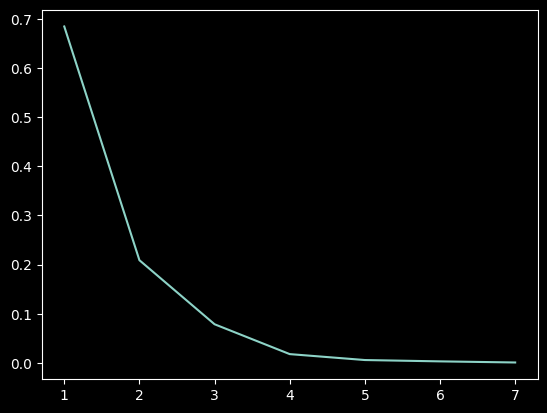

In [7]:
from sklearn.decomposition import PCA

Xtmp = data[s] # select data without the target asset
pca = PCA(n_components=len(s))
pca.fit(Xtmp)

n_comp = np.arange(1, len(s)+1)
plt.plot(n_comp, pca.explained_variance_ratio_)

In [8]:
pca.explained_variance_ratio_

array([0.6847219 , 0.20899449, 0.07863671, 0.01788126, 0.0058179 ,
       0.0030976 , 0.00085013])

# Parameter selection

In [9]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from itertools import product

def compute_votes(data, pca_comp, beta, lookback, Cs, gammas, epsilons):
    '''
    compute daily votes of the models with the given parameters
    '''
    # start with equal weights
    weights = np.ones(len(Cs)*len(gammas)*len(epsilons))
    weights = weights/sum(weights) # normalize so that weights sum to 1

    daily_votes = [x for x in np.zeros(len(data.index))]

    for t in range(lookback,len(data.index)-1):
        predictions = []
        for C,gamma,epsilon in product(Cs,gammas,epsilons):
            model = make_pipeline(StandardScaler(), PCA(n_components=pca_comp), 
                                  SVR(C=C, gamma=gamma, epsilon=epsilon))
            X_train = data[s].iloc[t-lookback:t+1].values
            y_train = data[y].iloc[t-lookback:t+1].values.flatten()
            model.fit(X_train,y_train)
            X_test = data[s].iloc[t].values.reshape(1,-1)
            yhat = model.predict(X_test)
            predictions.append(yhat)
        # log all votes
        votes = -np.sign(data[y].iloc[t].values.flatten() - np.array(predictions)) # if price>fair, go short
        final_vote = np.dot(weights,votes)
        daily_votes[t] = final_vote

        # update weights based on true direction
        true_direction = np.sign((data[y].iloc[t+1] - data[y].iloc[t]).values.flatten()) 
        if final_vote!=true_direction:
            incorrect_votes_ind = np.where(votes!=true_direction)[0]
            weights[incorrect_votes_ind] = beta * weights[incorrect_votes_ind]
            weights = weights/sum(weights)

    return daily_votes

In [10]:
# SVR hyperparameters
Cs = set((0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000))
gammas = set((0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000))
epsilons = set((0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1))

In [55]:
# strategy parameters
betas = [0.1,0.3] # ,0.5,0.7] # betas for downgrading weights
lookbacks = [20] # how many last trading days to include in model training
pca_comps = [1] # number of principal components to use

In [56]:
columns = ['Beta', 'Lookback', 'PCA components', 'Num wins', 'Num losses', 'Pct Win', 
           'Avg Win', 'Avg Loss', 'Total Return', 'APR', 'Sharpe', 'Correlation with traded asset']
results = pd.DataFrame(columns=columns)

vote_arrs = [compute_votes(data, pca_comp, beta, lookback, Cs, gammas, epsilons)
             for pca_comp,beta,lookback in product(pca_comps,betas,lookbacks)]

vote_arrs

In [53]:
columns = ['Beta', 'Lookback', 'PCA components', 'Num wins', 'Num losses', 'Pct Win', 
           'Avg Win', 'Avg Loss', 'Total Return', 'APR', 'Sharpe', 'Correlation with traded asset']
results = pd.DataFrame(columns=columns)

# for pca_comp,beta,lookback in product(pca_comps,betas,lookbacks):
#     daily_votes = compute_votes(data, pca_comp=pca_comp, beta=beta, lookback=lookback, 
#                                 Cs=Cs, gammas=gammas, epsilons=epsilons)
for i, obj in enumerate(product(pca_comps, betas, lookbacks)):
    daily_votes = vote_arrs[i]
    pca_comp = obj[0]
    beta = obj[1]
    lookback = obj[2]
    
    datatmp = data[['BP']].iloc[lookback+50:].copy() # skip first 50 days
    datatmp['vote'] = daily_votes[lookback+50:]
    datatmp['vote'] = datatmp['vote'].shift()
    datatmp['BP_returns'] = datatmp['BP'].pct_change()
    datatmp.dropna(inplace=True)
    # ar = np.sign(datatmp['vote'])
    datatmp['alg_returns'] = (np.sign(datatmp['vote']) * datatmp['BP_returns'])
    datatmp['alg_cumret'] = np.cumprod(datatmp['alg_returns']+1)
    # continue
    
    datatmp.dropna(inplace=True)
    
    num_wins = (np.sign(datatmp[['BP_returns']].values) == np.sign(datatmp[['vote']].values)).sum()
    num_losses = (np.sign(datatmp[['BP_returns']].values) != np.sign(datatmp[['vote']].values)).sum()
    pct_win = num_wins / (num_wins + num_losses)
    avg_win = abs(datatmp[np.sign(datatmp['BP_returns']) == np.sign(datatmp['vote'])]['BP_returns']).sum()/num_wins
    avg_loss = abs(datatmp[np.sign(datatmp['BP_returns']) != np.sign(datatmp['vote'])]['BP_returns']).sum()/num_losses
    tr_num = (datatmp[['alg_cumret']].iloc[-1].values[0] - datatmp[['alg_cumret']].iloc[0].values[0])
    tr_den = datatmp[['alg_cumret']].iloc[0].values[0]
    total_return = tr_num / tr_den
    apr = (1+total_return)**(252/len(datatmp.index)) - 1
    sharpe = np.sqrt(252)*datatmp['alg_returns'].mean() / datatmp['alg_returns'].std()
    corrcoef = np.nan # np.corrcoef(datatmp['BP_returns'], datatmp['alg_returns'])[0,1]
    
    result = pd.DataFrame({'Beta':beta, 'Lookback':lookback, 'PCA components':pca_comp, 
                           'Num wins':num_wins, 'Num losses':num_losses, 'Pct Win':pct_win, 
                           'Avg Win':avg_win, 'Avg Loss':avg_loss, 'Total Return':total_return, 
                           'APR':apr, 'Sharpe':sharpe, 'Correlation with traded asset':corrcoef}, 
                           index=[0])
    results = pd.concat([results, result], ignore_index=True)
    # results = results.append({'Beta':beta, 'Lookback':lookback, 'PCA components':pca_comp, 
    #                           'Num wins':num_wins, 'Num losses':num_losses, 'Pct Win':pct_win, 
    #                           'Avg Win':avg_win, 'Avg Loss':avg_loss, 'Total Return':total_return, 
    #                           'APR':apr, 'Sharpe':sharpe, 'Correlation with traded asset':corrcoef}, 
    #                           ignore_index=True)

/var/folders/2x/p6dc896s1_zfw89hllb_6gbw0000gn/T/ipykernel_43368/3352795804.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result], ignore_index=True)


In [54]:
results

,Beta,Lookback,PCA components,Num wins,Num losses,Pct Win,Avg Win,Avg Loss,Total Return,APR,Sharpe,Correlation with traded asset
0,0.1,20,1,85,94,0.47486,0.017603,0.0154,0.006928,0.009767,0.196688,NaN


In [ ]:
# strategy parameters
betas = [0.5] # betas for downgrading weights
lookbacks = [20] # how many last trading days to include in model training
pca_comps = [1,2,3] # number of principal components to use

In [ ]:
columns = ['Beta', 'Lookback', 'PCA components', 'Num wins', 'Num losses', 'Pct Win', 
           'Avg Win', 'Avg Loss', 'Total Return', 'APR', 'Sharpe', 'Correlation with traded asset']
results = pd.DataFrame(columns=columns)

for pca_comp,beta,lookback in product(pca_comps,betas,lookbacks):
    daily_votes = compute_votes(data, pca_comp=pca_comp, beta=beta, lookback=lookback, 
                                Cs=Cs, gammas=gammas, epsilons=epsilons)
    
    datatmp = data[['BP']].iloc[lookback+50:].copy() # skip first 50 days
    datatmp['vote'] = daily_votes[lookback+50:]
    datatmp['vote'] = datatmp['vote'].shift()
    datatmp['BP_returns'] = datatmp['BP'].pct_change()
    datatmp['alg_returns'] = (np.sign(datatmp['vote']) * datatmp['BP_returns'])
    datatmp['alg_cumret'] = np.cumprod(datatmp['alg_returns']+1)
    
    datatmp.dropna(inplace=True)
    
    num_wins = (np.sign(datatmp[['BP_returns']].values) == np.sign(datatmp[['vote']].values)).sum()
    num_losses = (np.sign(datatmp[['BP_returns']].values) != np.sign(datatmp[['vote']].values)).sum()
    pct_win = num_wins / (num_wins + num_losses)
    avg_win = abs(datatmp[np.sign(datatmp['BP_returns']) == np.sign(datatmp['vote'])]['BP_returns']).sum()/num_wins
    avg_loss = abs(datatmp[np.sign(datatmp['BP_returns']) != np.sign(datatmp['vote'])]['BP_returns']).sum()/num_losses
    total_return = (datatmp['alg_cumret'][-1] - datatmp['alg_cumret'][0]) / datatmp['alg_cumret'][0]
    apr = (1+total_return)**(252/len(datatmp.index)) - 1
    sharpe = np.sqrt(252)*datatmp['alg_returns'].mean() / datatmp['alg_returns'].std()
    corrcoef = np.corrcoef(datatmp['BP_returns'], datatmp['alg_returns'])[0,1]
    
    results = results.append({'Beta':beta, 'Lookback':lookback, 'PCA components':pca_comp, 
                              'Num wins':num_wins, 'Num losses':num_losses, 'Pct Win':pct_win, 
                              'Avg Win':avg_win, 'Avg Loss':avg_loss, 'Total Return':total_return, 
                              'APR':apr, 'Sharpe':sharpe, 'Correlation with traded asset':corrcoef}, 
                              ignore_index=True)

In [ ]:
results

# Model: beta=0.5, pca_comp=1

In [ ]:
daily_votes = compute_votes(data, pca_comp=1, beta=0.5, lookback=20, 
                            Cs=Cs, gammas=gammas, epsilons=epsilons)
    
datatmp = data[['BP']].iloc[lookback+50:].copy() # skip first 50 days
datatmp['vote'] = daily_votes[lookback+50:]
datatmp['vote'] = datatmp['vote'].shift()
datatmp['BP_returns'] = datatmp['BP'].pct_change()
datatmp['alg_returns'] = (np.sign(datatmp['vote']) * datatmp['BP_returns'])
datatmp['alg_cumret'] = np.cumprod(datatmp['alg_returns']+1)
datatmp.dropna(inplace=True)

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(datatmp[['BP']]/datatmp[['BP']].iloc[0], label='Target asset (BP)')
plt.plot(datatmp[['alg_cumret']]/datatmp[['alg_cumret']].iloc[0], label='Algorithm')
plt.legend()

In [ ]:
datatmp['SPY'] = data.loc[datatmp.index, ['SPY']]

plt.figure(figsize=(18,6))
plt.plot(datatmp[['SPY']]/datatmp[['SPY']].iloc[0], label='Market (SPY)')
plt.plot(datatmp[['alg_cumret']]/datatmp[['alg_cumret']].iloc[0], label='Algorithm')
plt.legend()

In [ ]:
# create an indicator of positions change
# -1 when we change position from long to short or vice versa
datatmp['pos_change'] = np.sign(datatmp['vote'])*np.sign(datatmp['vote'].shift())
datatmp['pos_change'][datatmp['pos_change']!=-1]=0
# subtract 0.2% fee from the return when we change position
datatmp['alg_returns_tc'] = datatmp['alg_returns'] + 0.002 * datatmp['pos_change']
# calculate cumulative returns with transaction costs
datatmp['alg_cumret_tc'] = np.cumprod(datatmp['alg_returns_tc']+1)

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(datatmp[['BP']]/datatmp[['BP']].iloc[0], label='Target asset (BP)')
plt.plot(datatmp[['alg_cumret_tc']]/datatmp[['alg_cumret_tc']].iloc[0], label='Algorithm with TC')
plt.legend()

In [ ]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    sharpe = np.sqrt(252) * np.nanmean(cumret.pct_change()) / np.nanstd(cumret.pct_change())
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [ ]:
metrics = pd.DataFrame(columns=['Total Return', 'APR', 'Sharpe', 'MaxDrawdown', 'MaxDrawdownDuration'], 
                       index=['BP', 'SPY', 'Algo', 'Algo with TC'])

metrics.loc['BP',:] = calculate_metrics(datatmp['BP'])
metrics.loc['SPY',:] = calculate_metrics(datatmp['SPY'])
metrics.loc['Algo',:] = calculate_metrics(datatmp['alg_cumret'])
metrics.loc['Algo with TC',:] = calculate_metrics(datatmp['alg_cumret_tc'])

metrics

In [ ]:
datatmp[['BP', 'SPY', 'alg_cumret', 'alg_cumret_tc']].pct_change().corr()